In [61]:
# Ensure the project root is in PATH.
import sys

sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

In [62]:
market_data_round_4_day_1 = pd.read_csv(os.path.join("..", "data", "round4", "prices_round_4_day_1.csv"), sep=";")
market_data_round_4_day_2 = pd.read_csv(os.path.join("..", "data", "round4", "prices_round_4_day_2.csv"), sep=";")
market_data_round_4_day_3 = pd.read_csv(os.path.join("..", "data", "round4", "prices_round_4_day_3.csv"), sep=";")

trades_round_4_day_1 = pd.read_csv(os.path.join("..", "data", "round4", "trades_round_4_day_1.csv"), sep=";")
trades_round_4_day_2 = pd.read_csv(os.path.join("..", "data", "round4", "trades_round_4_day_2.csv"), sep=";")
trades_round_4_day_3 = pd.read_csv(os.path.join("..", "data", "round4", "trades_round_4_day_3.csv"), sep=";")

observations_round_4_day_1 = pd.read_csv(os.path.join("..", "data", "round4", "observations_round_4_day_1.csv"), sep=",")
observations_round_4_day_2 = pd.read_csv(os.path.join("..", "data", "round4", "observations_round_4_day_2.csv"), sep=",")
observations_round_4_day_3 = pd.read_csv(os.path.join("..", "data", "round4", "observations_round_4_day_3.csv"), sep=",")

market_data_round_4_all3days = concatenate_historical_data([market_data_round_4_day_1, market_data_round_4_day_2, market_data_round_4_day_3])
trades_round_4_all3days = concatenate_historical_data([trades_round_4_day_1, trades_round_4_day_2, trades_round_4_day_3])
observations_round_4_all3days = concatenate_historical_data([observations_round_4_day_1, observations_round_4_day_2, observations_round_4_day_3])

In [63]:
MAGNIFICENT_MACARONS = "MAGNIFICENT_MACARONS"

md = market_data_round_4_day_3.copy()
th = trades_round_4_day_3.copy()
obs = observations_round_4_day_3.copy()

md = md[md["product"] == MAGNIFICENT_MACARONS]
th = th[th["symbol"] == MAGNIFICENT_MACARONS]


l, h = 0, 1e5
md = md[(md["timestamp"] >= l) & (md["timestamp"] <= h)].reset_index(drop=True)
th = th[(th["timestamp"] >= l) & (th["timestamp"] <= h)].reset_index(drop=True)
obs = obs[(obs["timestamp"] >= l) & (obs["timestamp"] <= h)].reset_index(drop=True)

obs["actual_ask"] = obs["askPrice"] + obs["transportFees"] + obs["importTariff"]
obs["actual_bid"] = obs["bidPrice"] - obs["transportFees"] - obs["exportTariff"]

# plt.plot(obs["timestamp"], obs["actual_ask"], label="actual_ask")
# plt.plot(obs["timestamp"], obs["actual_bid"], label="actual_bid")

# plt.plot(obs['timestamp'], obs['actual_ask']- obs['actual_bid']) # crossing the 'spread' is like $16, thats crazy bruh
# plt.legend()
# plt.show()

obs


,timestamp,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex,actual_ask,actual_bid
0,0,671.0,672.5,2.1,10.0,-3.0,199.000000,55.00,671.6,658.9
1,100,672.0,673.5,2.1,10.0,-3.0,199.064089,55.00,672.6,659.9
2,200,668.5,670.0,2.1,10.0,-3.0,198.783168,55.01,669.1,656.4
3,300,668.5,670.0,2.1,10.0,-3.0,198.545120,55.02,669.1,656.4
4,400,668.0,669.5,2.1,10.0,-3.0,198.455261,55.02,668.6,655.9
...,...,...,...,...,...,...,...,...,...,...
996,99600,591.5,593.0,2.0,10.0,-3.5,196.786784,59.98,591.5,579.5
997,99700,590.5,592.0,2.0,10.0,-3.5,196.829248,59.98,590.5,578.5
998,99800,593.0,594.5,2.0,10.0,-3.5,196.948061,59.99,593.0,581.0
999,99900,595.0,596.5,2.0,10.0,-3.5,197.164183,60.00,595.0,583.0


Spread of (obs_actual_ask - bid_price_1):
Mean=3.9533466533466655
Std=0.936789045087686

Spread of (ask_price_1 - bid_price_1):
Mean=8.7002997002997
Std=1.096762063105231

Spread of (obs_actual_ask - obs_actual_bid):
Mean=12.488111888111913
Std=0.4308629580040135



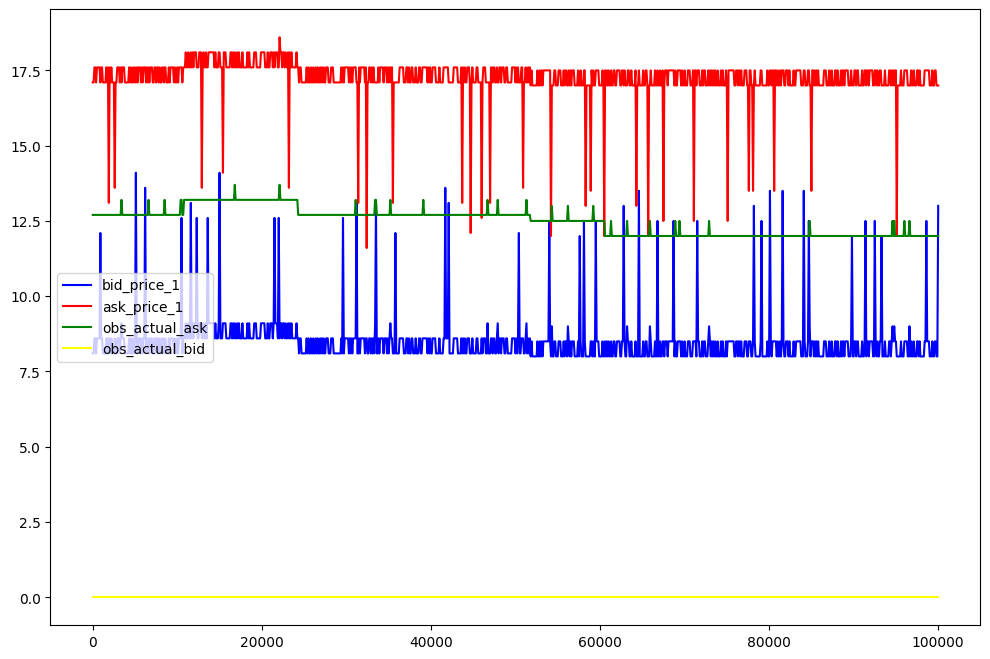

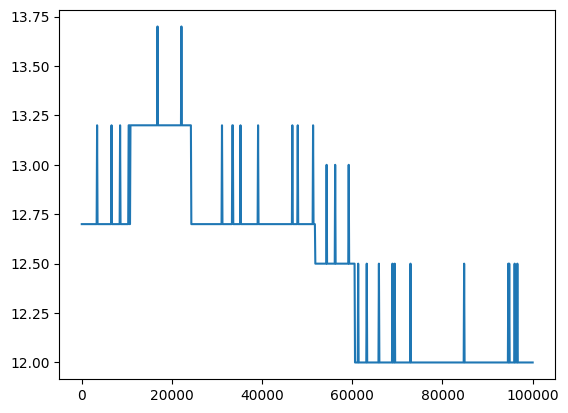

In [94]:
data = pd.DataFrame(
    {
        "timestamp": md["timestamp"],
        "bid_price_1": md["bid_price_1"],
        "ask_price_1": md["ask_price_1"],
        "obs_actual_ask": obs["actual_ask"],
        "obs_actual_bid": obs["actual_bid"],
    }
)




def calc_spread(col1, col2):
    mean = np.mean(data[col1] - data[col2])
    std = np.std(data[col1] - data[col2])
    return f"Spread of ({col1} - {col2}):\nMean={mean}\nStd={std}\n"


print(calc_spread("obs_actual_ask", "bid_price_1"))
print(calc_spread("ask_price_1", "bid_price_1"))
print(calc_spread('obs_actual_ask', 'obs_actual_bid'))

# normalise
data["bid_price_1"] -= data["obs_actual_bid"]
data["ask_price_1"] -= data["obs_actual_bid"]
data["obs_actual_ask"] -= data["obs_actual_bid"]
data["obs_actual_bid"] -= data["obs_actual_bid"]
plt.figure(figsize=(12,8))


# mask = data['obs_actual_ask'] <= data['obs_actual_ask'].shift(1)
# data['obs_actual_ask'] = data['obs_actual_ask'][mask]
# print(np.sum(mask))
plt.plot(data['timestamp'], data['bid_price_1'], label='bid_price_1', color='blue')
plt.plot(data['timestamp'], data['ask_price_1'], label='ask_price_1', color='red')
plt.plot(data['timestamp'], data['obs_actual_ask'], label='obs_actual_ask', color='green')
plt.plot(data['timestamp'], data['obs_actual_bid'], label='obs_actual_bid', color='yellow')
plt.legend()
plt.show()


plt.figure()
plt.plot(data['timestamp'], data['obs_actual_ask'])
# plt.plot(data['timestamp'], data['obs_actual_ask'].rolling(5).mean())
k = 4
# plt.plot(data['timestamp'], data['bid_price_1'] + k, label=f"bid_price_1+{k}", color='black')



